In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# <i class="fas fa-circle" style="color: #f0ad4e;"></i> Introduction to projections and least squares 
<span style="background-color: #f0ad4e; color: white; border-radius: 10px; padding-top: 2px; padding-bottom: 2px; padding-left: 6px;padding-right: 6px;">exercise</span><span style="background-color: #343A40; color: white; border-radius: 10px; padding-top: 2px; padding-bottom: 2px; padding-left: 6px;padding-right: 6px;">notebook</span>

This exercise guides you through the basics of linear projections and how they can be used for a simple but widespread machine learning technique: least squares. The focus of this section is to show you the basics. A more practical approach that is useful in practice is shown in the next part.

## Projections
Remember from the book that a projection is a transformation that maps vectors onto a subspace in such a manner that the distances between original and projected points are minimised. 

Let's look at an example to make it more tangible. We start by defining a set of points $x_1, \dots, x_n$ (`points` in the code) and a line $U$ (defined as $y=0.5x$) that we want to project the points onto:


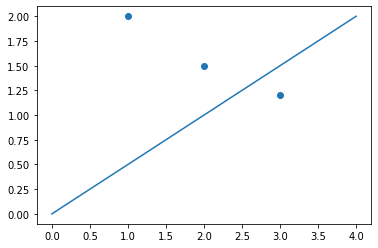

In [58]:
# Three points
points = np.array([
    [1, 2],
    [2, 1.5],
    [3, 1.2]
])

# Show plot
plt.scatter(points[:, 0], points[:, 1])

# Make line points (remember Numpy broadcasting)
x = np.linspace(0, 4)
y = x*0.5

# Plot line
plt.plot(x, y)


In this situation, projecting the points onto $U$ is done by multiplying by the projection matrix $P$, i.e. $\hat{x}_i = Px_i$. The resulting points $\hat{x}_i$ should then be "on" the line $U$. Let's try to accomplish exactly this by implementing the procedure in code.

First, we need to determine the projection matrix $P$ using the formula from the book:
$$
\begin{align}
P = A(A^TA)^{-1}A^T
\end{align}
$$

In our case we want the line $U$ to be represented as the matrix $A$. From $y=0.5x$ we get the matrix $U = [1, 0.5]$. The projection matrix is then easy to calculate:


In [99]:
U = np.array([[2, 1]]).T # U has to be a column vector
P = U.dot(np.linalg.inv((U.T.dot(U))).dot(U.T))


We now perform the projection itself ($\hat{x}_i = Px_i$):


In [100]:
x_hat = P.dot(points.T)
x_hat


array([[1.6 , 2.2 , 2.88],
       [0.8 , 1.1 , 1.44]])

Now, we want to *see* whether this actually worked or not. To do this, we plot the projected points as well as the old points and line:


(0.0, 4.0)

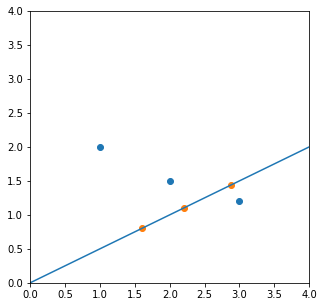

In [101]:
# Creating a square figure (makes it easier to visually confirm projection)
plt.figure(figsize=(5, 5))

# Plot everything
plt.scatter(points[:, 0], points[:, 1]) # Old points
plt.scatter(x_hat[0, :], x_hat[1, :]) # Projected points
plt.plot(x, y) # Line

# Set axes limits to be the same for equal aspect ratio
plt.xlim(0, 4)
plt.ylim(0, 4)


Okay, it actually worked. As you should be able to verify, it clearly looks like the points are perpendicular to the line. 

This hopefully gave you a bit of an overview of this projection process from a practical perspective. Below are a few exercises that should test your understanding.

### Tasks
1. Try changing the points and line (remember to update the line matrix $U$ as well) and see if things still work.
2. The book states that for projections $P^2=P$. Test if this works in practice as well (you just have to duplicate the line doing the transformation)
3. Explain (and write this down in your notes) why it makes sense that $P^2=P$. Make an argument that doesn't rely on the algebra but uses only your spatial and geometric intuition.
4. When applying projections, the resulting vectors are still in the original vector space, e.g. in this example both the original and projected points are in $R^2$. However, it is possible to get the positions in the subspace itself ($R^1$ because the subspace is a line in this case). To do this, you simply modify the projection matrix formula to the following: $\hat{P} = (A^TA)^{-1}A^T$ (the leading $A$ is dropped. The notation $\hat{P}$ is not official is is just used here for convenience). Try to apply this projection to the original points and compare the values with the 2d ones (hint: use length for comparing them).


## Least squares
Later in the course, projections are going to be used for other purposes, but for now the primary purpose is fitting linear models. A *linear model* is just a linear function (i.e. anything you can express with matrix operations) but using the term *model* makes it clear that our aim is to optimise it somehow for some purpose.

For now, we focus on a simple two-dimensional case. As in the video lecture from the week on transformations, we have three points that don't quite fit a line perfectly:


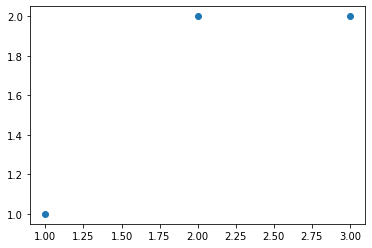

In [26]:
points = np.array([
    [1, 1],
    [2, 2],
    [3, 2]
])
plt.scatter(points[:, 0], points[:, 1])


We want to end up with a line that minimises some form of error, i.e. a best fitting line. This does, however, require us to look a bit differently on the problem than we did previously. In the previous section we projected a set of points onto an existing line. Now, we want to find a line that minimises the error of projecting the points onto it. The heart of the problem is the linear equation

$$
Ax = b
$$

Here, $x$ is the unknown and represents a line. This might be confusing because $x$ represented points in the previous section. Another way to understand this is that for a linear function of the form $f(x) = a*x + b$, we may write this in matrix form as either $[a, b]\binom{x}{1} = y$ or $[x, 1]\binom{a}{b} = y$. In other words we may either view the function in terms of the variables $x, y$ or the parameters $a, b$. Because we are fitting a line, we want to find the parameters $a, b$ given a number of already provided $(x, y)$ points. Writing out the full equation therefore gives us: 

$$
\left[\begin{array}{cc}x_1 & 1\\\vdots & \vdots \\x_n&1\end{array}\right] \binom{a}{b} = \mathbf{y} = \left[\begin{array}{c}y_1\\ \vdots \\y_n\end{array}\right]
$$

where $a, b$ are the unknown parameters we want to find. The $1$'s column is what allows this compact notation - it ensures that $b$ is treated as constant. Now, $A$'s column vectors are each elements of $R^n$ but only span a plane ($R^2$) in this space. This space represents all possible valid lines. Since $\mathbf{y}$ might not be placed on this plane, we cannot solve the equations directly.

As demonstrated in the book and lectures, we first have to project $\mathbf{y}$ onto the plane spanned by $A$. This leads to a new equation $A\hat{x}=\hat{\mathbf{y}}$ which **can** be solved using inverses. 


### Starting out
We start by creating the matrix $A$ (called the **Design Matrix**):


In [27]:
x_vals = points[:, 0]
y_vals = points[:, 1]


X = np.vstack((x_vals, np.ones(x_vals.shape))).T
X


array([[1., 1.],
       [2., 1.],
       [3., 1.]])

### Projection
Instead of transforming the line parameters $\hat{x}$ back into $R^n$ when projecting ($n$ is from the design matrix which has $n$ rows, one for each point), we use the same method you were tasked with implementing in the last section. This gives the equation: $\hat{x} = (A^TA)^{-1}A^T \mathbf{\hat{y}}$ (see the [ST] book page 222 for details):


In [53]:
# Creating the matrix
Pm = np.linalg.inv(X.T.dot(X)).dot(X.T)

# Applying the transformation
params = Pm.dot(points[:, 1])


### Testing
Now we want to visualise the resulting line. The `params` vector is of the form $(a, b)$ and the line formula is $f(x)=ax+b$. Below, we calculate a number of points on the line for visualisation purposes and compare with both the original and projected points:


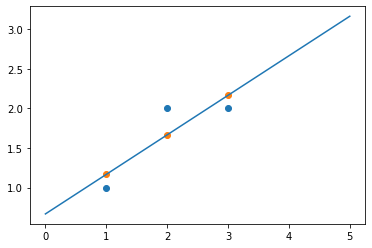

In [54]:
x = np.linspace(0, 5) # Create range of values
y = x*params[0] + params[1] # Calculate f(x)

plt.plot(x, y) # Plot line
plt.scatter(points[:, 0], points[:, 1]) # Plot original points

y_hat = X.dot(params) # Project original points onto the line (like in the last section)
plt.scatter(points[:, 0], y_hat) # Plot the points


This looks promising. Only the y-positions have moved and the resulting line looks reasonably optimal. However, we need to define some method of evaluating the quality of the fit in a quantitative manner.

Remember that both $\mathbf{y}$ and $\mathbf{\hat{y}}$ are vectors. The projection error vector is defined as $e = \mathbf{y}-\mathbf{\hat{y}}$. We use the length of this vector, denoted $||e||_2$, as our error measure. The full equation is:

$$
||e||_2 = \sqrt{\sum_{i=1}^n e_i^2} = \sqrt{\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$ 

We want to be able to compare errors from datasets of different sizes. We therefore modify the measure to use the averageI  squared error instead:

$$
f_{RMS}(\mathbf{y}, \mathbf{\hat{y}}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

Let us start by calculating the error vector itself:


In [10]:
y_hat = X.dot(params)
e = y_vals-y_hat
e


array([-0.16666667,  0.33333333, -0.16666667])

And then find the $f_{RMS}$:


In [11]:
np.sqrt((e**2).mean())


0.23570226039551595

This completes our basic walkthrough of least squares. The next exercise introduces you to how this is done in practice for actual problems using high-level Python libraries. First, however, we conclude this section by asking a number of questions that should help you think about what the least squares method actually is and how it works. Take your time to try and answer these as they are likely a good indicator of things you are expected to understand for the exam.

### Tasks
1. Try experimenting with changing the points and adding/removing points. What is the minimum number of points required for the method to work and why?
2. How does the $f_{RMS}$ compare with the visual fit of the line? Try exploring different possibilities and write down your observations.
3. Remember that matrices are functions. When solving equations of the type $Ax = b$, $A$ is then a function and $x$ is the variables. Explain in your own words why line fitting uses the parameters $a, b$ as unknowns. 
4. If you understand (3), then you should be able to explain why polynomials can be fitted using least squares. A polynomial is a function of the form $f(x, \theta) = \sum_{i=0}^n \theta_ix^i$, where $\theta$ is a vector of the parameters. For a regular 2d polynomial, this expands to $f(x) = c + bx + ax^2$. The crucial idea is that polynomials are linear when considering the parameters $\theta$. (The next exercise might give you a better idea of why this is the case).
